# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


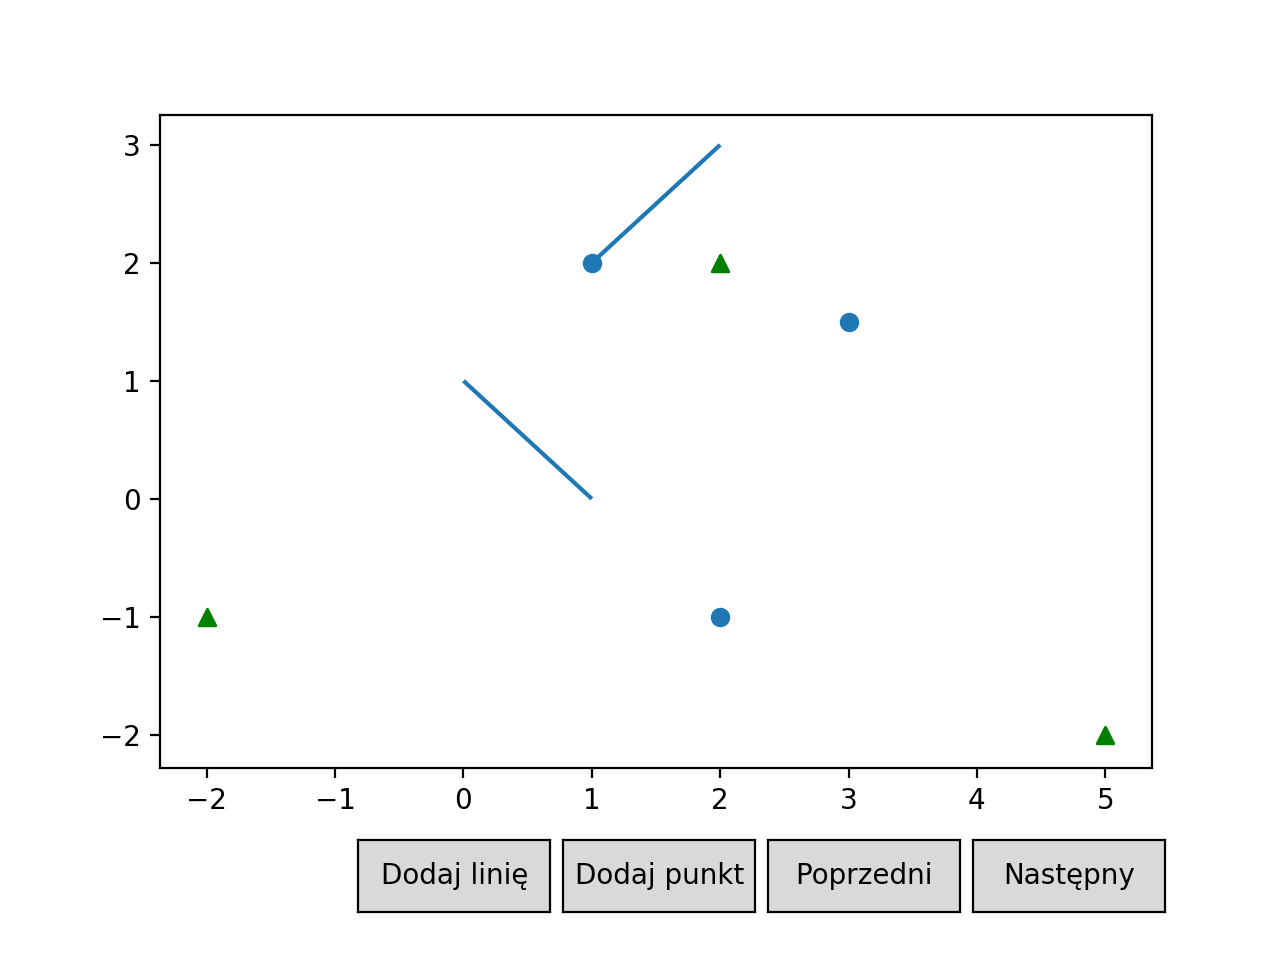

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


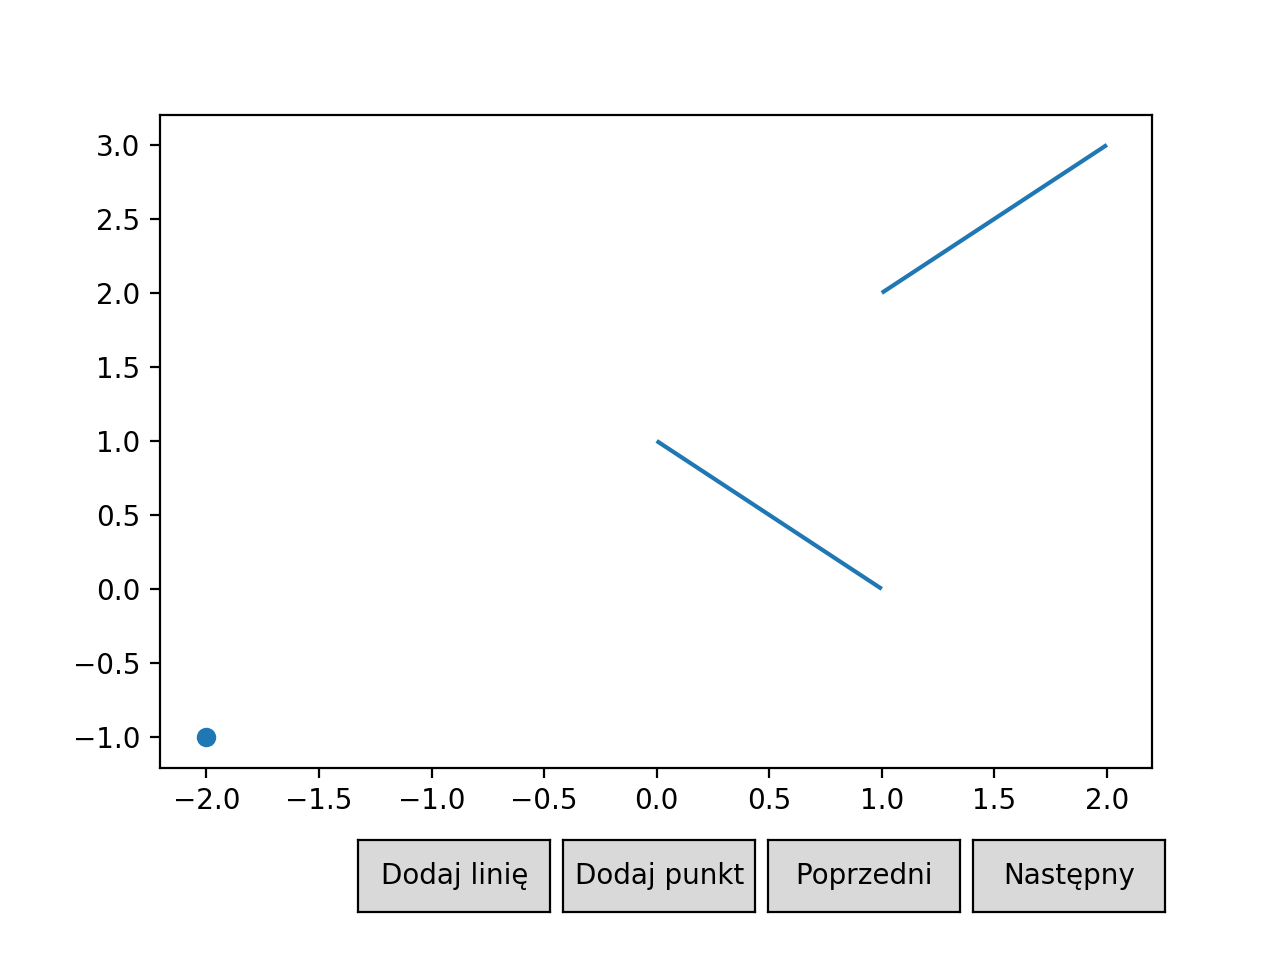

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


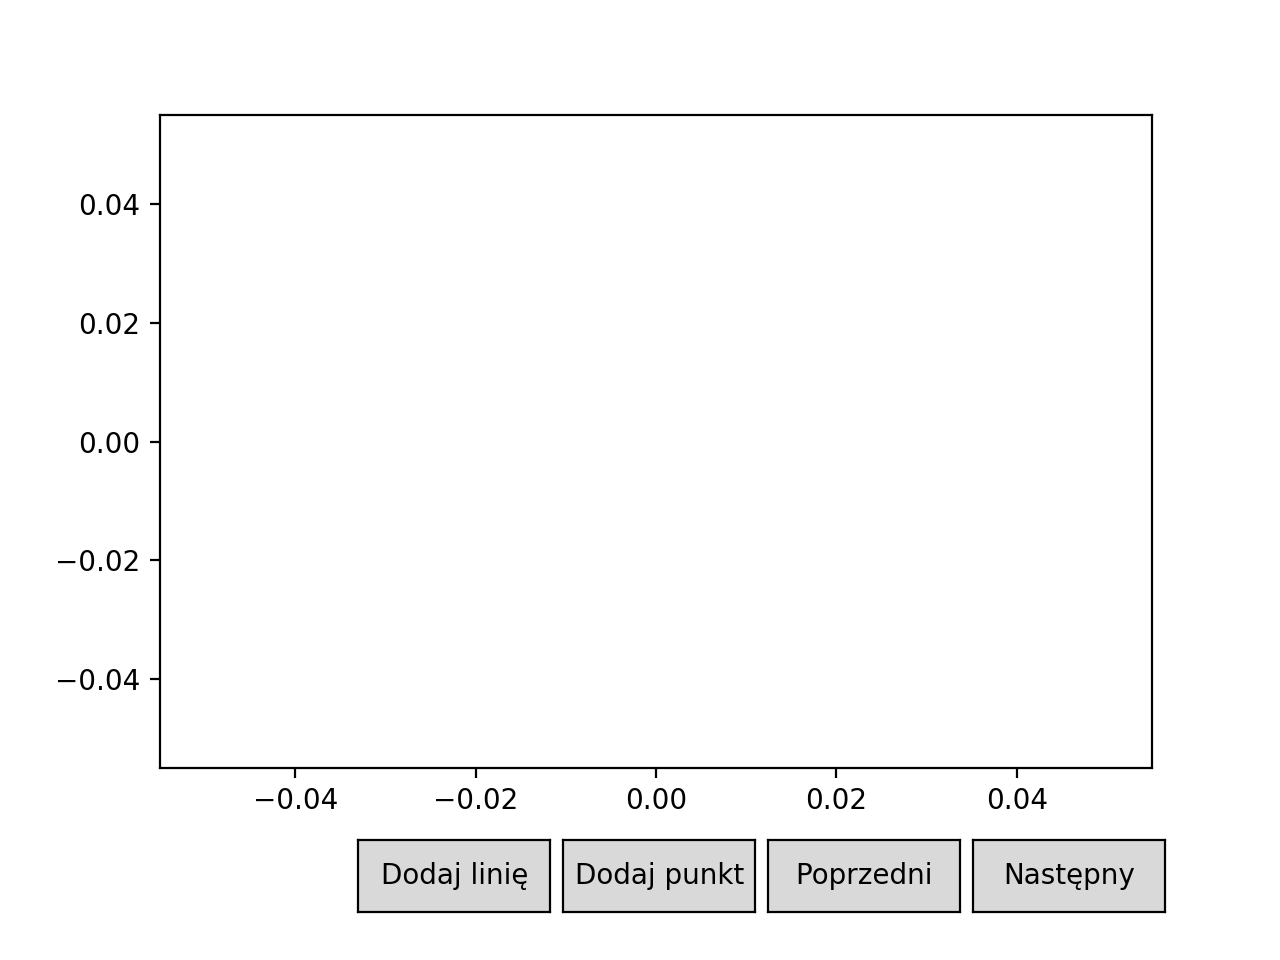

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


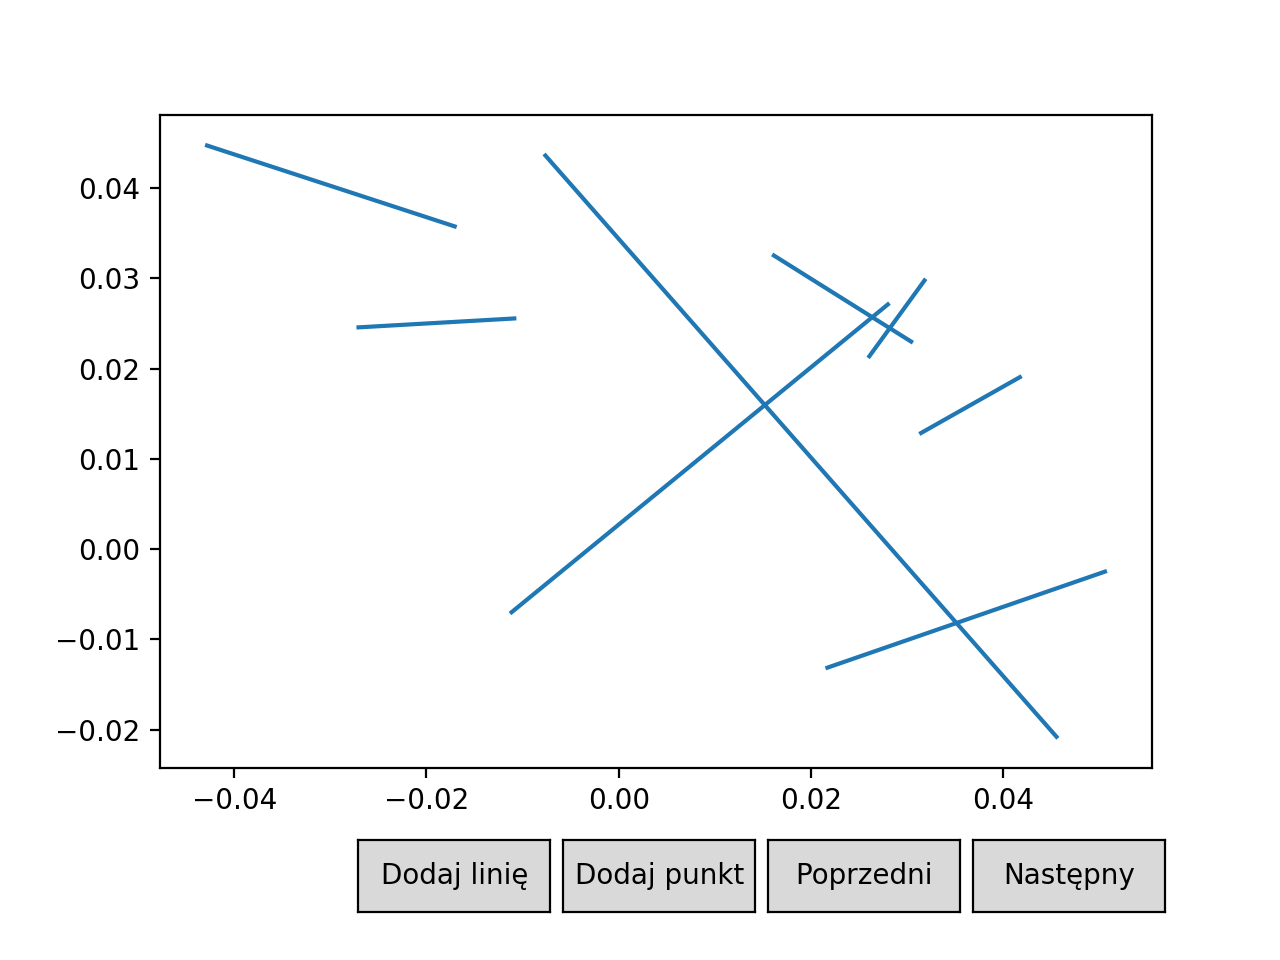

In [17]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [6]:
#TODO: implement self-balancing BST instead od BST (???)
#TODO: now implementation assumes that there is no more then 1 currently active line for each y position

class Node:
    def __init__(self, key, idx):
        self.key = key
        self.idx = idx
        self.left = None
        self.right = None
        self.parent = None

class LineState:
    def __init__(self):
        self.idx_to_node = dict()
        self.root = None
        
    def swap(self, idx1, idx2):
        self.idx_to_node[idx1], self.idx_to_node[idx2] = self.idx_to_node[idx2], self.idx_to_node[idx1]
        self.idx_to_node[idx1].idx = idx1
        self.idx_to_node[idx2].idx = idx2
    
    def pred(self, idx):
        node = self.idx_to_node.get(idx, None)

        if(self.root is None):
            return None
        
        if(node is None):
            print("nie ok pred", "idx = ", idx)
            return None
          
        if(not node.left is None):
            node = node.left
            while(not node.right is None):
                node = node.right
            return node
        
        if((not node.parent is None) and node.parent.right is node):
            return node.parent
        
        if((not node.parent is None) and node.parent.left is node):
            while((not node.parent is None) and node.parent.left is node):
                node = node.parent
            return node.parent
        
        return None
    
    def succ(self, idx):
        node = self.idx_to_node.get(idx, None)

        if(self.root is None):
            return None
        
        if(node is None):
            print("nie ok succ", "idx = ", idx)
            return None
        if(not node.right is None):
            node = node.right
            while(not node.left is None):
                node = node.left
            return node
        
        if((not node.parent is None) and node.parent.left is node):
            return node.parent
        
        if((not node.parent is None) and node.parent.right is node):
            while((not node.parent is None) and node.parent.right is node):
                node = node.parent
            return node.parent
        
        return None
    
    def insert(self, key, idx):
        node = Node(key, idx)
        self.idx_to_node[idx] = node
        if(self.root is None):
            self.root = node
            return
        
        par = self.root
        
        while(True):
            if(par.key > node.key):
                if(par.left is None):
                    par.left = node
                    node.parent = par
                    break
                else:
                    par = par.left
            else:
                if(par.right is None):
                    par.right = node
                    node.parent = par
                    break
                else:
                    par = par.right
    
    def remove(self, idx):
        node = self.idx_to_node.get(idx, None)
        if(node is None):
            print("nie ok remove", "idx = ", idx)
            return
        
        del self.idx_to_node[idx]
        
        if (self.root is node) and (node.left is None) and (node.right is None):
            self.root = None
            del node
            return
        
        if not node.left is None:
            if not node.right is None:
                right_most = node.left
                while(not right_most.right is None):
                    right_most = right_most.right
                right_most.right = node.right
                node.right.parent = right_most
            
            node.left.parent = node.parent
            
            if node is self.root:
                self.root = node.left
            else:
                if(node.parent.left is node):
                    node.parent.left = node.left
                else:
                    node.parent.right = node.left
            del node
            return
        
        if not node.right is None:
            node.right.parent = node.parent
            
            if node is self.root:
                self.root = node.right
            else:
                if node.parent.left is node:
                    node.parent.left = node.right
                else:
                    node.parent.right = node.right
            del node
            return
        
        if node.parent.left is node:
            node.parent.left = None
        else:
            node.parent.right = None
        del node
        

### Sweeping Algorithm

In [7]:
def intersection(a, b, eps=0.00009):
    r = (a[1][0]-a[0][0], a[1][1]-a[0][1])
    s = (b[1][0]-b[0][0], b[1][1]-b[0][1])
    
    rxs = r[0]*s[1] - r[1]*s[0] #if rxs = 0 then lines colinear
    
    
    if(rxs > eps or rxs < -eps):
        q_p = (b[0][0] - a[0][0], b[0][1] - a[0][1])
        t = (q_p[0]*s[1] - q_p[1]*s[0]) / rxs
        u = (q_p[0]*r[1] - q_p[1]*r[0]) / rxs
        
        if((t >= 0. and t<=1.) and (u >= 0. and u <= 1.)):
            return (a[0][0] + t*r[0], a[0][1] + t*r[1])
        else:
            return (None, None)
    else:
        return (None, None)

In [8]:
def check(idx, neighbour, Q, lines, intersections):
    b = lines[idx]
    if(not neighbour is None):
        neighbour_idx = neighbour.idx
        a = lines[neighbour_idx]
            
        x,y = intersection(a, b)
        
        if not x is None:
            if(intersections.get((neighbour_idx, idx), 0) == 0):
                intersections[(neighbour_idx, idx)] = 1
                intersections[(idx, neighbour_idx)] = 1
                Q.put((x, 2, idx, neighbour_idx))

In [9]:
def checkNeighbours(idx, T, lines, Q, intersections):
    n1 = T.pred(idx)
    n2 = T.succ(idx)
    
    check(idx, n1, Q, lines, intersections)
    check(idx, n2, Q, lines, intersections)

In [10]:
%matplotlib notebook

lines = []

with open('test_points.json') as f:
    lines = Plot(json=f.read()).scenes[0].lines[0].lines

In [11]:
from queue import PriorityQueue

# TODO: if intersection point is end1-begin2 we don't garantee the begin2 will be before the end1 in queue

Q = PriorityQueue() # contains of (priority, begin(0)/end(1)/intersect(2), idx1[, idx2(only if intersect)])

for i in range(len(lines)):
    lines[i].sort()
    lines[i][0][0] *= 10
    lines[i][0][1] *= 10
    lines[i][1][0] *= 10
    lines[i][1][1] *= 10

for idx, i in enumerate(lines):
    Q.put((i[0][0], 0, idx))
    Q.put((i[1][0], 1, idx))
    
T = LineState()
intersections = dict()

while(not Q.empty()):
    action = Q.get()
    if(action[1] == 0):
        _, _, idx = action
        
        T.insert(lines[idx][0][1], idx)
        checkNeighbours(idx, T, lines, Q, intersections)
    elif(action[1] == 1):
        _, action_type, idx = action
        
        n1 = T.pred(idx)
        n2 = T.succ(idx)
        
        T.remove(idx)
        
        if not n1 is None:
            checkNeighbours(n1.idx, T, lines, Q, intersections)
        if not n2 is None:
            checkNeighbours(n2.idx, T, lines, Q, intersections)
    else:
        _, _, idx1, idx2 = action
        T.swap(idx1, idx2)
        
        for idx in [idx1, idx2]:
            checkNeighbours(idx, T, lines, Q, intersections)

print(len(intersections.keys())//2) # 4 expected

4


<IPython.core.display.Javascript object>


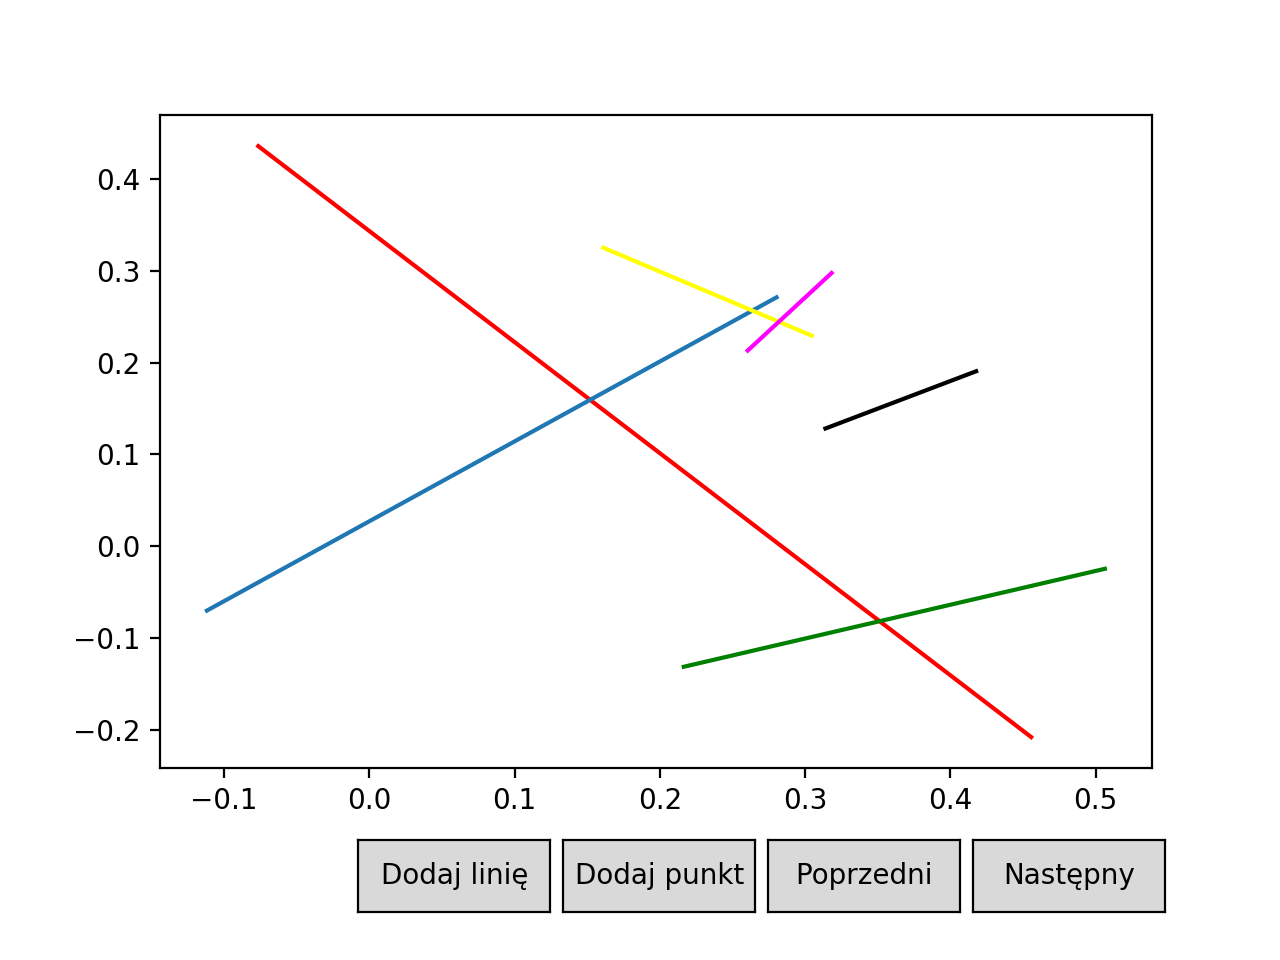

In [12]:
plot = Plot([Scene([], [LinesCollection([lines[2]], color='red'), LinesCollection([lines[3]]), LinesCollection([lines[7]], color='green'), LinesCollection([lines[4]], color='yellow'), LinesCollection([lines[6]], color='black'), LinesCollection([lines[5]], color='magenta')])]  )
plot.draw()

In [30]:
print(intersection(lines[5], lines[3]))

-1.400629052024029
(None, None)
(None, None)


In [13]:
print(lines[5])

[[0.25940345641105395, 0.2117795607622934], [0.31928248866911857, 0.2994021097819012]]
